<a href="https://colab.research.google.com/github/Holanpasaribu12/UAS/blob/main/Uas_Citra_Digital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python matplotlib numpy


Sistem Absensi Otomatis Berbasis Deteksi Wajah

Daftar Mahasiswa:
1. Asiholan Pandapotan Pasaribu (NIM: 20235520005)
2. Imanuel Andreas Gulo (NIM: 20235520009)
3. Jeriko Ichtus Seo (NIM: 20235520002)
Masukkan nomor mahasiswa (1-3) atau 0 untuk keluar: 1

Memproses absensi untuk Asiholan Pandapotan Pasaribu (NIM: 20235520005)
Silakan upload foto wajah. Tekan cancel untuk memakai absensi terakhir.


Saving download (2).png to download (2).png
Foto terdeteksi menggunakan filter Hitam Putih (Grayscale). Silakan unggah foto wajah tanpa filter.
Silakan unggah foto yang valid.


Saving download.png to download.png
Foto terdeteksi menggunakan filter Hitam Putih (Grayscale). Silakan unggah foto wajah tanpa filter.
Silakan unggah foto yang valid.


Saving holan.filterNegatif.jpg to holan.filterNegatif.jpg
Tidak ada wajah yang terdeteksi. Silakan unggah foto yang mengandung wajah.
Silakan unggah foto yang valid.


Saving gweh.jpg to gweh.jpg

Absensi untuk Asiholan Pandapotan Pasaribu (NIM: 20235520005):
Date: 2025-12-02, Time: 10:29:52 WIB
Face Detected: Yes
Image Size: 480x853 pixels
Status: Hadir


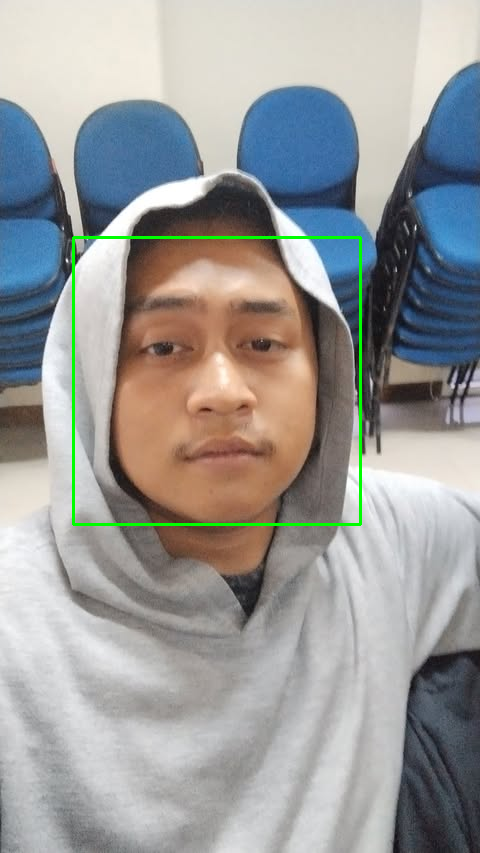


=== Beberapa Foto yang TIDAK BOLEH Di-upload ===


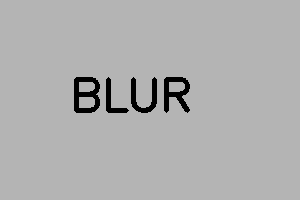

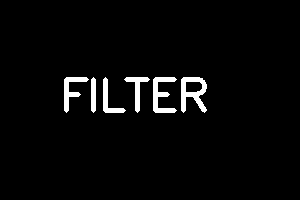

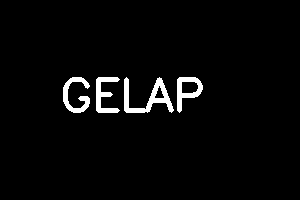

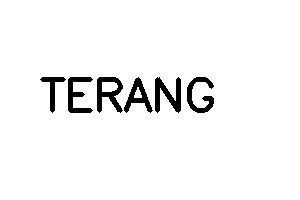

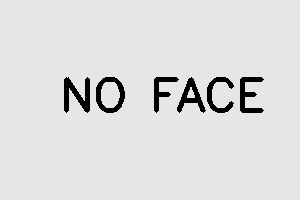

Absensi berhasil dicatat.

Daftar Mahasiswa:
1. Asiholan Pandapotan Pasaribu (NIM: 20235520005)
2. Imanuel Andreas Gulo (NIM: 20235520009)
3. Jeriko Ichtus Seo (NIM: 20235520002)
Masukkan nomor mahasiswa (1-3) atau 0 untuk keluar: 0
Keluar dari sistem absensi.

Log Absensi Akhir:


,Student_Name,NIM,Date,Time,Face_Detected,Image_Size,Status
0,Asiholan Pandapotan Pasaribu,20235520005,2025-12-02,10:19:21 WIB,Yes,747x1024 pixels,Hadir
1,Asiholan Pandapotan Pasaribu,20235520005,2025-12-02,10:29:52 WIB,Yes,480x853 pixels,Hadir


In [3]:
import cv2
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.patches import cv2_imshow
from datetime import datetime
import os
import pytz
from scipy.stats import entropy

# Initialize student data with NIM
students = {
    "Asiholan Pandapotan Pasaribu": "20235520005",
    "Imanuel Andreas Gulo": "20235520009",
    "Jeriko Ichtus Seo": "20235520002"
}

# Create or load attendance database
attendance_file = 'attendance_log.csv'
if os.path.exists(attendance_file):
    attendance_df = pd.read_csv(attendance_file)
else:
    attendance_df = pd.DataFrame(columns=['Student_Name', 'NIM', 'Date', 'Time', 'Face_Detected', 'Image_Size', 'Status'])

# Function to check if image is blurry using Laplacian variance
def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

# Function to detect various filters
def detect_filter(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2]):
        return "Hitam Putih (Grayscale)"

    img_negative = 255 - img
    diff = np.mean(np.abs(img.astype(float) - img_negative.astype(float)))
    if diff < 50:
        return "Negatif"

    b, g, r = cv2.split(img)
    if np.mean(r) > np.mean(g) * 1.1 and np.mean(g) > np.mean(b) * 1.1:
        return "Sepia"

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    if np.std(saturation) > 100 or entropy(saturation.flatten()) < 4:
        return "Kontras Tinggi atau Saturasi Berlebih"

    mean_intensity = np.mean(gray)
    if mean_intensity < 50 or mean_intensity > 200:
        return "Kecerahan Ekstrem (Terlalu Gelap/Terang)"

    return None

# Function to process image and record attendance
def process_attendance(image_path, student_name, student_nim):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    img = cv2.imread(image_path)
    if img is None:
        print("Error: Tidak dapat memuat gambar.")
        return False

    if is_blurry(img):
        print("Foto terdeteksi blur. Silakan unggah foto yang jelas tanpa blur.")
        return False

    filter_type = detect_filter(img)
    if filter_type:
        print(f"Foto terdeteksi menggunakan filter {filter_type}. Silakan unggah foto wajah tanpa filter.")
        return False

    # ------------------------------------------------------------
    # TAMBAHAN: PENGOLAHAN CITRA DIGITAL
    # ------------------------------------------------------------

    # 1. Grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Biner
    _, binary_img = cv2.threshold(grayscale_img, 127, 255, cv2.THRESH_BINARY)

    # 3. Histogram Equalization
    equalized_img = cv2.equalizeHist(grayscale_img)

    # 4. Morfologi (Opening)
    kernel = np.ones((5,5), np.uint8)
    morph_img = cv2.morphologyEx(grayscale_img, cv2.MORPH_OPEN, kernel)

    # 5. Segmentasi (Canny)
    edges = cv2.Canny(grayscale_img, 100, 200)

    # ------------------------------------------------------------

    # Face detection using equalized image
    gray = equalized_img
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("Tidak ada wajah yang terdeteksi. Silakan unggah foto yang mengandung wajah.")
        return False

    (x, y, w, h) = faces[0]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Timestamp
    wib = pytz.timezone('Asia/Jakarta')
    current_time = datetime.now(wib)
    date_str = current_time.strftime('%Y-%m-%d')
    time_str = current_time.strftime('%H:%M:%S WIB')

    face_detected = "Yes"
    height, width = img.shape[:2]
    status = "Hadir"

    global attendance_df
    new_record = pd.DataFrame({
        'Student_Name': [student_name],
        'NIM': [student_nim],
        'Date': [date_str],
        'Time': [time_str],
        'Face_Detected': [face_detected],
        'Image_Size': [f"{width}x{height} pixels"],
        'Status': [status]
    })
    attendance_df = pd.concat([attendance_df, new_record], ignore_index=True)
    attendance_df.to_csv(attendance_file, index=False)

    # OUTPUT ABSENSI
    print(f"\nAbsensi untuk {student_name} (NIM: {student_nim}):")
    print(f"Date: {date_str}, Time: {time_str}")
    print(f"Face Detected: {face_detected}")
    print(f"Image Size: {width}x{height} pixels")
    print(f"Status: {status}")
    cv2_imshow(img)

    # ------------------------------------------------------------
    # TAMPILKAN INFO SESUAI PERMINTAAN
    # ------------------------------------------------------------
    print("\n=== Beberapa Foto yang TIDAK BOLEH Di-upload ===")

    # Foto blur
    blur_example = np.ones((200, 300, 3), dtype=np.uint8) * 180
    blur_example = cv2.GaussianBlur(blur_example, (51, 51), 0)
    cv2.putText(blur_example, "BLUR", (70, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
    cv2_imshow(blur_example)

    # Foto filter
    filter_example = np.zeros((200, 300, 3), dtype=np.uint8)
    cv2.putText(filter_example, "FILTER", (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2_imshow(filter_example)

    # Gelap
    dark = np.zeros((200, 300, 3), dtype=np.uint8)
    cv2.putText(dark, "GELAP", (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2_imshow(dark)

    # Terang
    bright = np.ones((200, 300, 3), dtype=np.uint8) * 255
    cv2.putText(bright, "TERANG", (40, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
    cv2_imshow(bright)

    # Tanpa wajah
    no_face = np.ones((200, 300, 3), dtype=np.uint8) * 230
    cv2.putText(no_face, "NO FACE", (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
    cv2_imshow(no_face)

    return True


# Function to process last attendance if upload is cancelled
def process_last_attendance(student_name, student_nim):
    if not attendance_df.empty and attendance_df['Student_Name'].iloc[-1] == student_name:
        last_record = attendance_df.iloc[-1]
        print(f"\nAbsensi terakhir untuk {student_name} (NIM: {student_nim}) digunakan:")
        print(f"Date: {last_record['Date']}, Time: {last_record['Time']}")
        print(f"Face Detected: {last_record['Face_Detected']}")
        print(f"Image Size: {last_record['Image_Size']}")
        print(f"Status: {last_record['Status']}")
        return True
    else:
        print("Tidak ada catatan absensi sebelumnya.")
        return False


# MAIN PROGRAM
print("Sistem Absensi Otomatis Berbasis Deteksi Wajah")
while True:
    print("\nDaftar Mahasiswa:")
    for i, (name, nim) in enumerate(students.items(), 1):
        print(f"{i}. {name} (NIM: {nim})")

    try:
        student_idx = int(input("Masukkan nomor mahasiswa (1-3) atau 0 untuk keluar: ")) - 1
        if student_idx == -1:
            print("Keluar dari sistem absensi.")
            break
        elif 0 <= student_idx < len(students):
            student_name = list(students.keys())[student_idx]
            student_nim = students[student_name]
            print(f"\nMemproses absensi untuk {student_name} (NIM: {student_nim})")
            print("Silakan upload foto wajah. Tekan cancel untuk memakai absensi terakhir.")

            while True:
                uploaded = files.upload()
                if not uploaded:
                    if process_last_attendance(student_name, student_nim):
                        break
                    else:
                        continue

                image_path = list(uploaded.keys())[0]
                with open(image_path, 'wb') as f:
                    f.write(uploaded[image_path])

                if process_attendance(image_path, student_name, student_nim):
                    print("Absensi berhasil dicatat.")
                    os.remove(image_path)
                    break
                else:
                    os.remove(image_path)
                    print("Silakan unggah foto yang valid.")
        else:
            print("Nomor mahasiswa tidak valid.")
    except ValueError:
        print("Masukkan nomor yang valid (0-3).")

# Display attendance records
print("\nLog Absensi Akhir:")
if not attendance_df.empty:
    from IPython.display import display
    display(attendance_df)
else:
    print("Tidak ada catatan absensi.")
